# fbb skeleton notebook for PUI2017 HW6

Nina Nurrahmawati / nn1221

In [1]:
from __future__ import print_function, division
import pandas as pd
import pylab as pl
import seaborn
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

%pylab inline

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

In [2]:
# download the data
nrg = pd.read_csv('https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD', encoding='latin1')
# previously I extrated the table attributes from pluto shapefiles to csv format using QGIS and upload it to my github
bsize = pd.read_csv('https://raw.githubusercontent.com/ninanrh/PUI2017_nn1221/master/HW6_nn1221/MNMapPLUTO.csv', encoding='latin1')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,21,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
nrg.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ftÃÂ²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ftÃÂ²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract'

In [4]:
bsize.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistr', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'Fac

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

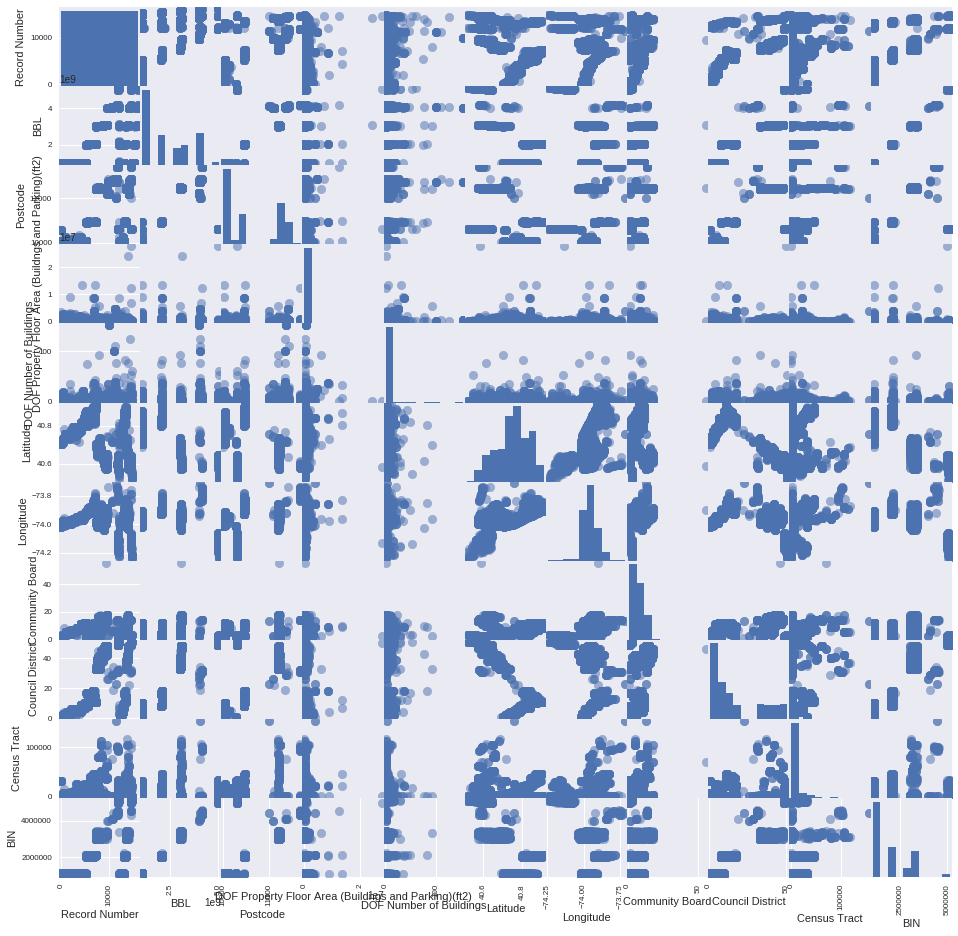

In [5]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16));

> Figure 1: scatter matrix of all numerical values in the energy consumption files. 

> From 32 columns, only 11 columns that appear to have numerical values. 

In [6]:
# convert string to numeric values
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
# check whether the conversion worked
print (nrg['Site EUI(kBtu/ft2)'].astype(float))

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16       125.4
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
16140      NaN
16141      NaN
16142      NaN
16143      NaN
16144      NaN
16145      NaN
16146      NaN
16147      NaN
16148      NaN
16149      NaN
16150      NaN
16151      NaN
16152      NaN
16153      NaN
16154      NaN
16155      NaN
16156      NaN
16157      NaN
16158      NaN
16159      NaN
16160      NaN
16161      NaN
16162      NaN
16163      NaN
16164      NaN
16165      NaN
16166      NaN
16167      NaN
16168      NaN
16169      NaN
Name: Site EUI(kBtu/ft2), dtype: float64


In [7]:
# change numerical values 
bsize.BBL.astype(float)

0        1.000010e+09
1        1.000090e+09
2        1.000158e+09
3        1.000130e+09
4        1.000010e+09
5        1.000010e+09
6        1.000130e+09
7        1.000090e+09
8        1.000030e+09
9        1.000120e+09
10       1.000030e+09
11       1.000168e+09
12       1.000160e+09
13       1.000030e+09
14       1.000120e+09
15       1.000030e+09
16       1.000030e+09
17       1.000130e+09
18       1.000090e+09
19       1.000090e+09
20       1.000300e+09
21       1.000328e+09
22       1.000318e+09
23       1.000080e+09
24       1.000290e+09
25       1.000290e+09
26       1.000390e+09
27       1.000020e+09
28       1.000350e+09
29       1.000070e+09
             ...     
42656    1.008968e+09
42657    1.010778e+09
42658    1.010478e+09
42659    1.013428e+09
42660    1.014298e+09
42661    1.014738e+09
42662    1.018878e+09
42663    1.018438e+09
42664    1.016308e+09
42665    1.018318e+09
42666    1.019448e+09
42667    1.018448e+09
42668    1.019438e+09
42669    1.019448e+09
42670    1

In [8]:
# throw unnecessary columns
nrg = nrg.loc[:,['BBL','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ftÂ²)']]
bsize = bsize.loc[:,['BBL', 'UnitsTotal', 'UnitsRes', 'YearBuilt']]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/indexes/base.py:2097: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


In [9]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ftÂ²)
0,1.000410e+09,NaN,NaN
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,NaN
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,NaN


In [10]:
# Check how many missing values
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). You can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data _type_ is the same:printing the columns the content may look the same but your computer wont know it is the same if it is a different data type (e.g. '1' string is not the same as 1 integer'. '1' == 1 returns False)! both have to be integers, both strings, or whatever, but the same, or you will not be able to merge. 

In [11]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010200.9999999, 1000410001.0)

In [12]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape

(0, 6)

ValueError: zero-size array to reduction operation minimum which has no identity

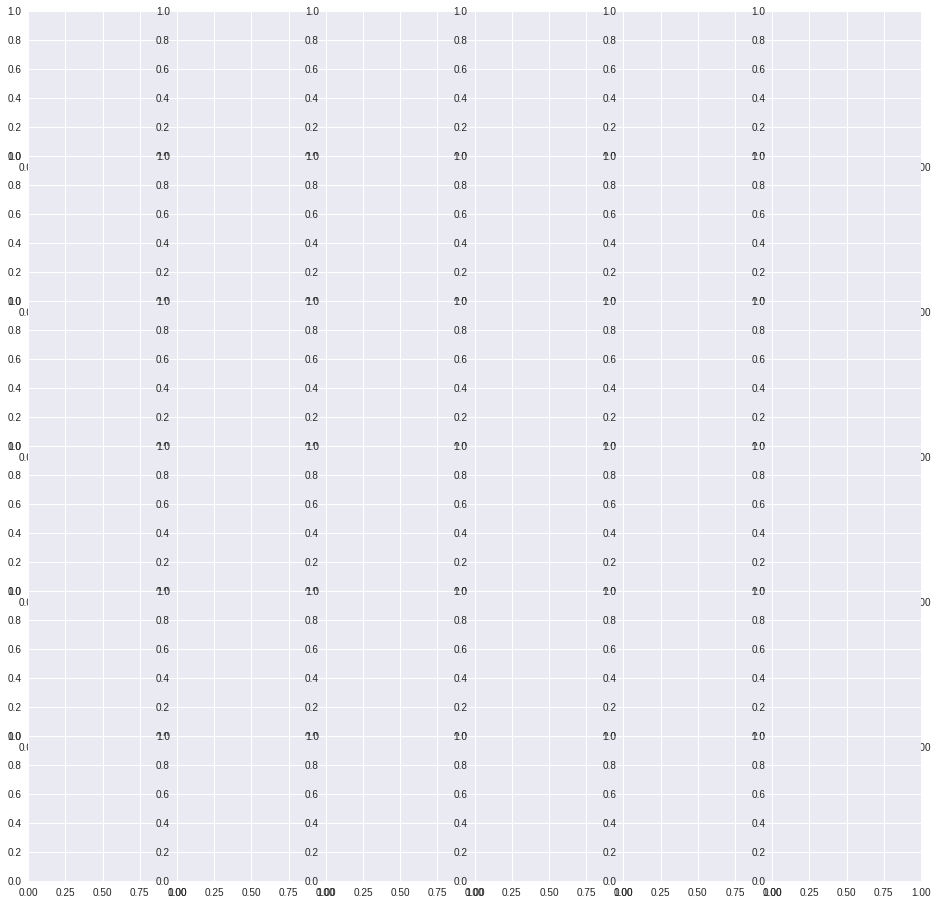

In [13]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));

> Figure 2: scatter matrix of final dataset. The plot of UnitsTotal and UnitsRes against energy consumption have similiar plot and most of the consumption below 10,000 kBtu/ft2. 

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [14]:
# change weird column name
bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ftÂ²)']
bblnrgdata = bblnrgdata.drop(['Reported Property Floor Area (Building(s)) (ftÂ²)'], axis=1 )

In [15]:
# convert to float
bblnrgdata['Reported Property Floor Area (Building(s))'] = bblnrgdata['Reported Property Floor Area (Building(s))'].astype(float)
bblnrgdata['UnitsTotal'] = bblnrgdata['UnitsTotal'].astype(float)

In [16]:
# check dtypes
print (bblnrgdata.dtypes)

BBL                                           float64
Site EUI(kBtu/ft2)                            float64
UnitsTotal                                    float64
UnitsRes                                        int64
YearBuilt                                       int64
Reported Property Floor Area (Building(s))    float64
dtype: object


In [17]:
# convert energy total
bblnrgdata['energy'] =  bblnrgdata['Site EUI(kBtu/ft2)'].mul(bblnrgdata['Reported Property Floor Area (Building(s))'], axis=0).astype(float)

In [18]:
bblnrgdata.head(2)

,BBL,Site EUI(kBtu/ft2),UnitsTotal,UnitsRes,YearBuilt,Reported Property Floor Area (Building(s)),energy


In [20]:
# first scatter plot
bblnrgdata.plot(kind='scatter', x='energy', y='UnitsTotal', color='m', s=15, alpha=0.5, label='Energy Consumption \n(kBtu)', figsize=(12, 7.5))
pl.legend(loc=1, fontsize = 'medium')
pl.title('Scatter Plot Energy Consumption against Total Unit', fontsize=20)
pl.xlabel('Total Energy Consumption \n(kBtu)', fontsize=15)
pl.ylabel('Number of Units', fontsize=15)

TypeError: Empty 'DataFrame': no numeric data to plot

> Figure 3: Scatter plot of total energy consumption per number of units.

> This figure shows that majority of building whatever number of total unit has less than 500,000,000 kBtu energy consumption, eventhought some of them also have higher energy consumption with lower number or total units.

In [ ]:
# zoomed in scatter plot
ax2 = bblnrgdata.plot(kind='scatter', x='energy', y='UnitsTotal', color='m', s=15, alpha=0.5, 
                label='Energy Consumption \n(kBtu)', figsize=(12, 7.5))
pl.legend(loc=1, fontsize = 'medium')
pl.title('Scatter Plot Energy Consumption against Total Unit', fontsize=20)
pl.xlabel('Total Energy Consumption \n(kBtu)', fontsize=15)
pl.ylabel('Number of Units', fontsize=15)
ax2.set_ylim([0,1000])
ax2.set_xlim([10,175000000])

> Figure 4: Zoomed scatter plot of total energy consumption per number of units.

> In this zoomed figure shows that majority of building tend to concenrate having 200 or below total unit with energy consumption below 4,000,000 kBTu. There are some lower unit building that consume energy higher, probably those are non residential building.

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **
**try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and expand the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. You can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000] - see below.

Also I removed the buildings with several thousand units. Points like that at the edge of my range would have a lot of "LEVERAGE", however they are not spurious entries like the 0, which I believe are missing values, or perhaps abandoned lots. These are good datapoint that I need to throw away functionally for my analysis to work, but that should be stated clearly in your report.


In [ ]:
# thinking about outliers
bblnrgdata.describe()

In [ ]:
# from statistics descriptive above I decide to filter the data 'energy' > 1000 and 5 <= 'UnitsTotal' < 600
# cut the data
bblnrgdataCut = bblnrgdata[(bblnrgdata.energy > 1000) & (bblnrgdata.UnitsTotal>=5) & 
                           (bblnrgdata.UnitsTotal<600)]
# plot the data
ax = bblnrgdataCut.plot(kind='scatter', y='energy', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True, color='m')
ax.set_xlabel("Number of Units in Building", fontsize=20)
ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

> Figure 5: Log plot of total energy consumption per number of units.

> This log plot shows that the it nearly has a linear line.

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 




1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

    The function is :
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value  model($x_i$) is the prediction, data($x_i$) the observation,
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors?? see next point)
    
4. *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

5. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

6. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * log(Likelihood_Model1 / Likelihood_Model2) 

    or equivalently
        
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2) 
    
    where Model1 is the _least complex_ (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels. (Model1.llf)
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferable to Model2. The LR is chi^2 distributed with number of degrees of freedom $N_{DOF}$ = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.

In [ ]:
# independent variable (x) is bulding size and dependent variable (y) is energy
X = np.log10(bblnrgdataCut.UnitsTotal)
Y = np.log10(bblnrgdataCut.energy)
lm = smf.OLS(Y, sm.add_constant(X), missing='drop').fit()

In [ ]:
lm.summary()

In [ ]:
# dfsort = bblnrgdataCut.sort_values(by='UnitsTotal')

In [ ]:
ax2 = bblnrgdataCut.plot(kind='scatter', y='energy', x='UnitsTotal', 
                   marker='o',  figsize=(10, 8), loglog=True, color='c', alpha=0.75)
# ax = pl.subplot()
# ax.scatter(X, Y)
ax2.plot(10**X, 10**lm.fittedvalues, '--m', linewidth = 2) # change the log format, credit for Ben Steers
ax2.set_xlabel("Number of Units in Building", fontsize=20)
ax2.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

> Figure 6. Linear Model between Number of Units and Energy Consumption. From the picture above it seems that there is linear relationship between Number of Units and Energy Consumption, the scatter plot is around the line.

`2.` **Fit a line** to Energy vs Units.

In [ ]:
# independent variable (x) is energy and dependent variable (y) is building size
X_ = np.log10(bblnrgdataCut.energy)
Y_ = np.log10(bblnrgdataCut.UnitsTotal)
lm2 = smf.OLS(Y_, sm.add_constant(X_), missing='drop').fit()

In [ ]:
lm2.summary()

In [ ]:
ax3 = bblnrgdataCut.plot(kind='scatter', y='UnitsTotal', x='energy', 
                   marker='o',  figsize=(10, 8), loglog=True, color='c', alpha=0.75)
ax3.plot(10**X_, 10**lm2.fittedvalues, '--m', linewidth = 2)
ax3.set_ylabel("Number of Units in Building", fontsize=20)
ax3.set_xlabel("Energy consumption per building (kBtu)", fontsize=20)

> Figure 7. Linear model between energy consumption to number of units. From the picture above the line does not fit the data well and most likely the error will be high.

`3.` **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function to calculate the chi square or you can write your own.

In [ ]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [ ]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#Below I am writing out some uncertainties - please explain the functional form that I used.
#errors on the measured quantities
errorsnrg = np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s))'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#These errors need to be propagated properly through the log


In [ ]:
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.energy / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

In [ ]:
print("DV Energy - IV Unit Total : {:.4f}".format(chi2(X, lm.predict(sm.add_constant(X)), errorsInLogNrg)))
print("DV Unit Total - IV Energy : {:.4f}".format(chi2(X_, lm.predict(sm.add_constant(X_)), errorsInLogUnits)))

> From the chi square above DV Unit Total - IV Energy is better than otherwise.

`4.` *Assume Poisson statistics* for the errors on the *independent variable*. Poisson statistics means your uncertainty is the square root of your measurement. I wrote down the formula for the errors. Please explain why I wrote it as I did.

- The total energy consumption is calculated based on `Reported Property Floor Area` and `Site EUI(kBtu/ft2)` therefore the error will come from its component. 
- The regression was operated in log, therefore the error needs to be converted into log also.

`5.` **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

In [ ]:
# polynomial 
dfpoly = pd.DataFrame({'energy': Y, 'units': X})
lmpoly = smf.ols('energy ~ units + I(units**2)', data=dfpoly).fit()
lmpoly.summary()

In [ ]:
ax4 = dfpoly.plot(kind='scatter', y='energy', x='units', 
                   marker='o',  figsize=(10, 8), color='c')
poly_fit = np.linspace(X.min(), X.max(), 100)
ax4.plot(poly_fit, lmpoly.predict({'units': poly_fit}), 'm', linewidth = 3)
ax4.set_xlabel("Number of Units", fontsize=15)
ax4.set_ylabel("Energy consumption per building (kBtu)", fontsize=15)
ax4.set_title("Total Number of Units against Total Energy Consumption (Log)", fontsize=20)

> Figure 8. Linear model between energy consumption to number of units transformed to log. From the picture above the line has better fit to the data and the higher R-squared although the R-squared tends to low.

`6.` **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**.

In [ ]:
print ("LR : ", - 2 * (lm.llf - (lmpoly.llf)))
print ("LR from statsmodels:", lmpoly.compare_lr_test(lm)[0])

> Chi square with alpha 0.05 and degree of freedom 1 is 3.84, therefore null hypothesis is rejected because LR is larger than critical value. Polynomial 2nd degree is better.

Grade: 2/10 - there are many errors right from the start. 